In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.markers as mks
import numpy as np
import pprint
import random as rn
from itertools import chain
import math
import multiprocessing
import copy
import random


In [98]:
# Parameters for standard configuration
NT = 400  # total number of TDR facilities available
ST = 0.975 # safety level threshold
M = 10**6  # total demands threshold
L = 1000  # Lambda: scaling factor for total number of facilities opened
A = 10  # Alpha: maximum number of neighborhoods that a neighborhood can serve
B = 10  # Beta: maximum number of neighborhoods that a neighborhood can be served by
G = 15  # Gamma: penalty for unit unmet demand
k = ["Water", "Food", "Medical Kit"]  # commodities type
v = dict(zip(k, [1, 1, 0.5]))  # unit volume of commodity k
w = dict(zip(k, [1, 0.25, 0.25]))  # unit weight of commodity k
cd = dict(zip(k, [2.5, 3, 0.333]))  # commodities demand of an injured in 1day
V = 150000 # Volume Capacity of TDR
W = 30480*5 # Weight Capacity of TDR

In [99]:
# Reading the File
n = [] # maximum number of TDR facilities that can be allocated in neighborhood i
s = [] # safety level of neighborhood i
elite_Chromosom = []
elites_fitness = math.inf
bad_chromosom_index = 0
x_nodes = []
y_nodes = []
No_nodes = 0 #number of nodes
No_supplierNodes = 0 # number of supplier nodes
No_demandNodes = 0 #number of demand nodes
supplier_nodes_index = []
supplier_nodes_name = []
demand_nodes_index = []
v_capacity = [] # volume capacity
v_demands_water = []
v_demands_food = []
v_demands_medicalkit = []
w_capacity = [] # weight capacity
v_demands = [] # volume demands
w_demands = [] # weight demands
dist = [] # distance between neighborhoods i and j
genetic_best_solution = np.nan
Allocation_Clusters = {}

def readfile(path: str):
    global No_nodes, No_supplierNodes, No_demandNodes, supplier_nodes_index, demand_nodes_index, n, v_demands
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    # print(lines)
    for i, line in enumerate(lines, start=1):
        if 2 < i:
            NodesAttributes = line.split(",")
            supplier_nodes_name.append(NodesAttributes[1])
            x_nodes.append(float(NodesAttributes[7]))
            y_nodes.append(float(NodesAttributes[8]))
            population = int(NodesAttributes[4])
            No_facility = int(NodesAttributes[6])
            n.append(No_facility)
            s.append(float(NodesAttributes[5]))
            v_capacity.append(V*(No_facility))
            w_capacity.append(W*No_facility)
            v_demands.append(sum([x * y * population for x, y in zip(list(v.values()), list(cd.values()))]))
            v_demands_water.append(v['Water'] * cd['Water'] * population)
            v_demands_food.append(v['Food'] * cd['Food'] * population)
            v_demands_medicalkit.append(v['Medical Kit'] * cd['Medical Kit'] * population)
            w_demands.append(sum([x * y * population for x, y in zip(list(w.values()), list(cd.values()))]))


    No_nodes = len(x_nodes)
    supplier_nodes_index = [index for index, s in enumerate(s) if s >= ST]
    demand_nodes_index = [index for index, s in enumerate(s) if s < ST]
    No_supplierNodes = len(supplier_nodes_index)
    No_demandNodes = len(demand_nodes_index)
    
    print("x_nodes = ", x_nodes, "\ny_nodes = ", y_nodes, "\nv_capacity = ",
        v_capacity, "\nw_capacity = ", w_capacity, "\nv_demands = ",
        v_demands, "\nw_demands =", w_demands, "\nSafty Levels = ", s)
    
    print("\nSumVolumeCapacities = ", sum(v_capacity[i] for i in supplier_nodes_index), "\nSumWeightCapacities = ", sum(w_capacity[i] for i in supplier_nodes_index),
          "\nSumVolumeDemands = ", sum(v_demands), "\nSumWeightDemands = ", sum(w_demands))
    
    print("\nNum of Nodes = ",No_nodes,
          "\nNum of Spplier Nodes = ", No_supplierNodes,
          "\nNum of demand Nodes = ", No_demandNodes,
          "\nSum of Facilities = ", sum([n[i] for i in supplier_nodes_index]),
          "\nSupplier Nodes Index = ", supplier_nodes_index,
          "\nDemand Nodes Index = ", demand_nodes_index)
    

readfile("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\Neighborhood_Data.txt")    

x_nodes =  [542854.6354575139, 544297.7334397715, 544944.215181266, 545825.418826526, 541240.2444018908, 539921.3650180083, 540175.8892363384, 540605.2459170669, 539128.6217184188, 537574.0052861953, 541602.5902471552, 542304.9197994834, 542259.151118977, 541522.5829327758, 546184.1424427144, 544978.7931347527, 545663.0204727789, 547881.51214989, 538914.6155979317, 534686.893008735, 543518.8594746208, 547080.3030648893, 541319.7851449214, 543220.0095095076, 542405.1251548771, 544162.6504610088, 550893.5400929973, 546508.6861207737, 548245.1148169972, 549254.8346710587, 548105.9195804857, 545616.740718483, 546071.1267206725, 543305.90639506, 545292.4495104905, 545082.5480190925, 549457.8557848195, 550944.8534072414, 552475.7698982758, 549675.2819713792, 547310.3965815576, 536145.5420112209, 535431.0558279892, 537240.8895195238, 539381.1751644257, 546648.7023844942, 539127.8325918401, 538275.1273844559, 537466.9793481054, 542635.9756636173, 540088.92828108, 541162.2788729379, 535553.4739

In [100]:
def DistMatrix():
    distmatrix = np.empty((No_nodes, No_nodes), dtype=float)
    for i in range(No_nodes):
        for j in range(No_nodes):
            distmatrix[i][j] = round(math.sqrt( pow(x_nodes[i]-x_nodes[j],2) + pow(y_nodes[i]-y_nodes[j],2)), 2)
    return distmatrix
distmatrix = DistMatrix()
pprint.pprint(distmatrix)

array([[    0.  ,  1517.52,  2162.  , ...,  9381.41,  8914.95, 10377.78],
       [ 1517.52,     0.  ,   652.11, ..., 10371.91, 10216.28, 11687.02],
       [ 2162.  ,   652.11,     0.  , ..., 10745.77, 10729.68, 12201.25],
       ...,
       [ 9381.41, 10371.91, 10745.77, ...,     0.  ,  3100.57,  3609.36],
       [ 8914.95, 10216.28, 10729.68, ...,  3100.57,     0.  ,  1471.57],
       [10377.78, 11687.02, 12201.25, ...,  3609.36,  1471.57,     0.  ]])


In [101]:
# Initial Population
Population = []
def generate_initial_population(pop_size):
    for ـ in range(pop_size):
        Chromosom = []
        selectable = demand_nodes_index.copy()
        for i in range(No_nodes):
            if (i <= No_demandNodes-1):
                j = rn.choice(selectable)
                selectable.remove(j)
            else:
                j = rn.choice(range(min(n),n[supplier_nodes_index[i-No_demandNodes]]+1))
            Chromosom.append(j)
        Population.append(Chromosom)
    return Population
Population = generate_initial_population(50)
# print(Population)

In [102]:

# Fitness
def distance(pop: list):
    global Allocation_Clusters
    distance_fitness = []
    d_supp = np.array([v_demands[s] for s in supplier_nodes_index])
    c_supp = np.array([i*V  for i in pop[No_demandNodes:]]) - d_supp
    d = np.array([v_demands[i] for i in demand_nodes_index])
    j = 0
    end = False
    for i in range(No_supplierNodes):
        dni = []
        while c_supp[i] >= d[j]:
            dni.append(pop[j])
            distance_fitness.append(distmatrix[supplier_nodes_index[i], pop[j]])
            c_supp[i] -= d[j]
            d[j] = 0
            j += 1
            if j == No_demandNodes:
                end = True
                break
        if end == True:
            break
        dni.append(pop[j])
        Allocation_Clusters[f'{supplier_nodes_index[i]}'] = dni
        d[j] -= c_supp[i]
        c_supp[i] = 0
        distance_fitness.append(distmatrix[supplier_nodes_index[i], pop[j]])
    return sum(distance_fitness)
def fitness(population: list):    
    global elite_Chromosom, elites_fitness, bad_chromosom_index
    if len(np.array(population).shape) == 1:
        population = [population]
    Fitness = []
    for pop in population:
        sum_facilities_fitness = sum(pop[No_demandNodes:])
        d = sum(v_demands)
        c = sum([V*i for i in pop[No_demandNodes:]])
        unmet_demand_fitness = abs(d-c)
        # if d-c > 0:
        #     unmet_demand_fitness = (d-c)
        #     Excess_capacity_Penalty = 0
        # else:
        #     unmet_demand_fitness = 0
        #     Excess_capacity_Penalty = 10000
        distance_fitness = distance(pop)
    #     print("\nTotal Facilities opened = ",sum_facilities_fitness,
    #   "\nUnmet Demand = ", unmet_demand_fitness,
    #   "\nTotal Distance = ",distance_fitness)
        Fitness.append(sum_facilities_fitness*L + unmet_demand_fitness*G + distance_fitness)
    bad_chromosom_index = Population.index(Population[Fitness.index(max(Fitness))])
    if min(Fitness) < elites_fitness:
        elites_fitness = min(Fitness)
        elite_Chromosom = Population[Fitness.index(min(Fitness))]
    return Fitness

# def normalize_list(input_list):
#     min_val = min(input_list)
#     max_val = max(input_list)
    
#     # برای جلوگیری از تقسیم بر صفر
#     if max_val == min_val:
#         return [0.0] * len(input_list)
    
#     normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
#     return normalized_list

# Fitness = fitness(Population)
# print(Fitness)

In [103]:
# Split Rank Selection
runstep = 0
changed = False
Ranking = range(1,len(Population)+1)
K = len(Ranking)
ChromosomsProb =[]
ProbsRange = []
for i in Ranking:
    if i <= K/2:
        ChromosomsProb.append((12*i)/(5*K*(K+2)))
    else:
        ChromosomsProb.append((28*i)/(5*K*(3*K+2)))
for index, i in enumerate(ChromosomsProb):
    if index == 0:
        ProbsRange.append([0,i])
    else:
        ProbsRange.append([ProbsRange[index-1][1], ProbsRange[index-1][1] + (i)])
def SRS_Selection(ChromosomsFitness: list):
    # global runstep, ProbsRange, changed
    # runstep += 1
    # if changed == False:
    #     if runstep > 500:
    #         ChromosomsProb =[]
    #         ProbsRange = []
    #         for i in Ranking:
    #             if i <= K/2:
    #                 ChromosomsProb.append(p_k2 + s * (i - K/2))
    #             else:
    #                 ChromosomsProb.append(c ** (i - 1))
    #         total_sum = sum(ChromosomsProb)
    #         for index, i in enumerate(ChromosomsProb):
    #             if index == 0:
    #                 ProbsRange.append([0,i/total_sum])
    #             else:
    #                 ProbsRange.append([ProbsRange[index-1][1], ProbsRange[index-1][1] + (i/total_sum)]) 
    #         changed = True
    selectedchromosomforcrossover = []
    SelectedChromosomForCrossOver = []
    # print(ProbsRange)
    ChromosomsFitnessSorted = sorted(ChromosomsFitness, reverse=True)
    ChromosomsIndexByFitness = [ChromosomsFitness.index(i) for i in ChromosomsFitnessSorted]
    # print(f"runsstep = {runstep}, probrange length = {len(ProbsRange)} => ChromosomsFitness length = {len(ChromosomsFitness)}")
    for _ in Ranking:
        r = rn.uniform(0,1)
        for index, j in enumerate(ProbsRange):
            if r > j[0] and r <= j[1]:
                selectedchromosomforcrossover.append(ChromosomsIndexByFitness[index])
                if len(selectedchromosomforcrossover) == 2:
                    SelectedChromosomForCrossOver.append(selectedchromosomforcrossover)
                    selectedchromosomforcrossover = []
                    break
    # print(f"SelectedChromosomForCrossOver length = {len(SelectedChromosomForCrossOver)}")
    return SelectedChromosomForCrossOver
# selectedChromosom = SRS_Selection(Fitness)
# print(selectedChromosom)

150


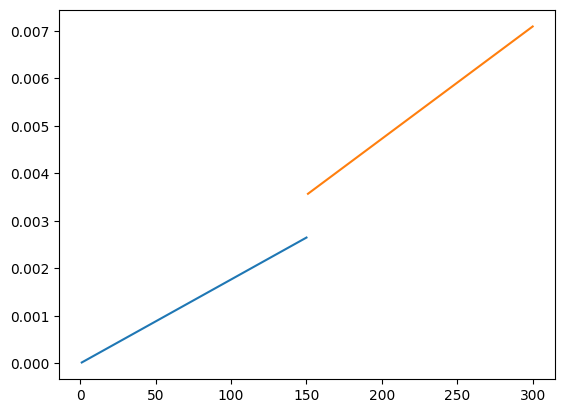

In [104]:
i = np.array(list(range(1, 151)))
h1 = []
K = 300
l1 = 0.2
l2 = 0.8
for j in i:
    h1.append(l1*(8*j)/(K*(K+2)))
plt.plot(i,h1)

i = np.array(list(range(151, K+1)))
h2 = []
for j in i:
    
    h2.append(l2*(8*j)/(K*(3*K+2)))
print(len(h2))
plt.plot(i,h2)

In [105]:
# Partial Mapped Crossover
def PMX_Crossover(selectedcrossover):
    childs = []
    for i in selectedcrossover:
        r = rn.uniform(0,1)
        if r <= 0.8:
            p1 = Population[i[0]]
            p2 = Population[i[1]]
            child1 = [1]*len(p1)
            child2 = [1]*len(p1)
            crossoverindex = rn.sample(list(range(No_demandNodes)),2)
            bp1 = p1[min(crossoverindex):max(crossoverindex)+1]
            bp2 = p2[min(crossoverindex):max(crossoverindex)+1]
            child1[min(crossoverindex):max(crossoverindex)+1] = bp2.copy()
            child2[min(crossoverindex):max(crossoverindex)+1] = bp1.copy()
            Chain = chain(range(min(crossoverindex)), range(max(crossoverindex)+1, len(child1)))
            for j in Chain:
                chekpoint1 = p1[j]
                chekpoint2 = p2[j]
                m = 0
                ch = False
                while chekpoint1 in bp2:
                    m += 1
                    chekpoint1 = bp1[bp2.index(chekpoint1)]
                    if m > len(bp2):
                        ch = True
                        child1[j] = p2[j]
                        break
                if ch == False:
                    child1[j] = chekpoint1
                m = 0
                ch = False
                while chekpoint2 in bp1:
                    m += 1
                    chekpoint2 = bp2[bp1.index(chekpoint2)]
                    if m > len(bp1):
                        ch = True
                        child2[j] = p1[j]
                        break
                if ch == False:
                    child2[j] = chekpoint2
                
                
            for index, i in enumerate(p2[No_demandNodes:]):
                child1[No_demandNodes+index] = i
                child2[No_demandNodes+index] = p1[No_demandNodes+index]
                
            childs.append(child1)
            childs.append(child2)
            
        else:
            childs.append(Population[i[0]])
            childs.append(Population[i[1]])
    return childs


# New Crossover
def New_Crossover(selectedcrossover, crossoverprob):
    childs = []
    for i1, i2 in selectedcrossover:
        if rn.uniform(0, 1) <= crossoverprob:
            for p1, p2 in [(Population[i1], Population[i2]), (Population[i2], Population[i1])]:
                child = [-1] * No_demandNodes
                rn1, rn2 = rn.randint(1, No_demandNodes // 2), rn.randint(No_demandNodes // 2, No_demandNodes - 2)
                
                joint = [r for r in range(rn1, rn2 + 1) if p1[r] in p2[rn1:rn2 + 1]]
                for r in joint:
                    child[r] = p1[r]
                
                for j in joint:
                    if child[j-1] == -1 and p2[j-1] not in child:
                        child[j-1] = p2[j-1]
                    if child[j+1] == -1 and p2[j+1] not in child:
                        child[j+1] = p2[j+1]

                c = 0
                for index, l in enumerate(child):
                    if l == -1:
                        while p2[c] in child:
                            c += 1
                        child[index] = p2[c]
                        c += 1
                childs.append(child + p1[No_demandNodes:])
        else:
            childs.extend([Population[i1], Population[i2]])

    return childs

In [106]:
# Mutation
def Mutation(childs: list):
    childsaftermutation = []
    for i in childs:
        r = rn.uniform(0,1)
        if r <= 0.2:
            rnd = rn.sample(list(range(No_demandNodes)),2)
            rnd0 = i[rnd[0]]
            rnd1 = i[rnd[1]]
            i[rnd[0]] = rnd1
            i[rnd[1]] = rnd0
            childsaftermutation.append(i)
            
            # rnd = rn.sample(list(range(No_demandNodes, len(i))),2)
            # rnd0 = i[rnd[0]]
            # rnd1 = i[rnd[1]]
            # if n[rnd[1]] > rnd0 and n[rnd[0]] > rnd1:
            #     i[rnd[0]] = rnd1
            #     i[rnd[1]] = rnd0
            # childsaftermutation.append(i)
        else:
            childsaftermutation.append(i)
    return childsaftermutation
# mutation = Mutation(childs)
# print(mutation)

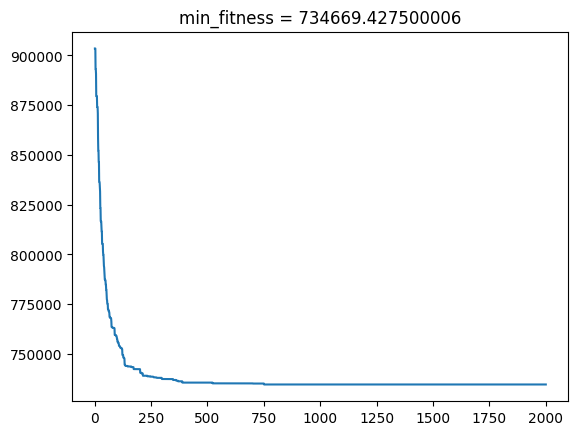

Best Solution =  [5, 18, 62, 63, 48, 50, 47, 11, 45, 17, 16, 35, 4, 24, 23, 0, 46, 7, 20, 40, 32, 1, 2, 21, 3, 27, 39, 29, 26, 37, 30, 25, 19, 41, 43, 52, 9, 8, 6, 59, 51, 13, 53, 56, 12, 55, 33, 15, 54, 61, 11, 5, 6, 5, 7, 2, 4, 12, 3, 6, 5, 2, 2, 2]

SumDemand =  10832268.3945 
SumSupply =  10800000

Total Facilities opened =  72 
Unmet Demand =  32268.394500000402 
Total Distance =  178643.51


In [107]:
# Generation
def Generation(repeat):
    global Population, genetic_best_solution
    g = range(1,repeat+1)
    minfit = []
    for i in range(repeat):
        Fitness = fitness(Population)
        minfit.append(min(Fitness) if (min(Fitness) <= elites_fitness) else elites_fitness)
        SelectedChromosoms = SRS_Selection(Fitness)
        Childs = New_Crossover(SelectedChromosoms, 0.95)
        childsaftermutation = Mutation(Childs)
        Population = childsaftermutation
        Population[bad_chromosom_index] = elite_Chromosom
    
    # Chromosom_Plot(InitialChromosoms[Fitness(InitialChromosoms).index(min(Fitness(InitialChromosoms)))])
    genetic_best_solution = Population[fitness(Population).index(min(fitness(Population)))]
    plt.plot(g,minfit)
    plt.title(f'min_fitness = {minfit[-1]}')
    plt.show()
    return genetic_best_solution
genetic_best_solution = Generation(2000)
print("Best Solution = ",genetic_best_solution)
print("\nSumDemand = ", sum(v_demands), "\nSumSupply = ", sum(V*n for n in genetic_best_solution[No_demandNodes:]))
print("\nTotal Facilities opened = ",sum(genetic_best_solution[No_demandNodes:]),
      "\nUnmet Demand = ", sum(v_demands)-sum(V*n for n in genetic_best_solution[No_demandNodes:]),
      "\nTotal Distance = ",distance(genetic_best_solution))

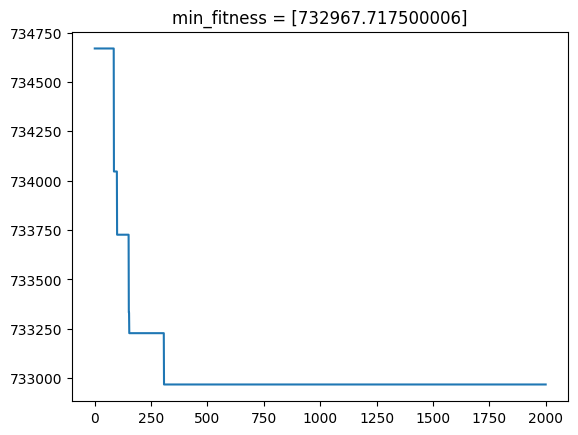

best_solution = [63, 47, 4, 18, 50, 5, 48, 11, 40, 17, 45, 33, 23, 0, 25, 46, 20, 24, 7, 35, 32, 2, 21, 3, 1, 27, 39, 26, 37, 29, 30, 41, 19, 43, 9, 8, 62, 52, 6, 51, 13, 56, 53, 59, 12, 55, 16, 15, 54, 61, 11, 5, 6, 5, 7, 2, 4, 12, 3, 6, 5, 2, 2, 2] 
 best_cost = [732967.717500006]
Best Solution =  [63, 47, 4, 18, 50, 5, 48, 11, 40, 17, 45, 33, 23, 0, 25, 46, 20, 24, 7, 35, 32, 2, 21, 3, 1, 27, 39, 26, 37, 29, 30, 41, 19, 43, 9, 8, 62, 52, 6, 51, 13, 56, 53, 59, 12, 55, 16, 15, 54, 61, 11, 5, 6, 5, 7, 2, 4, 12, 3, 6, 5, 2, 2, 2]

SumDemand =  10832268.3945 
SumSupply =  10800000

Total Facilities opened =  72 
Unmet Demand =  32268.394500000402 
Total Distance =  176941.79999999996


In [117]:
def generate_neighbors(current_solution):
    neighbors = []
    moves = []  # برای ذخیره حرکت‌ها

    # حرکت نوع 1: جابجایی در بخش اول
    for _ in range(No_demandNodes):  # تولید ۱۰ همسایه
        neighbor = copy.deepcopy(current_solution)
        i, j = random.sample(range(No_demandNodes), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        neighbors.append(neighbor)
        moves.append(("swap", i, j))

    # حرکت نوع 2: تغییر تعداد تسهیلات
    for k in range(No_supplierNodes):
        for change in [-1, 1]:
            neighbor = copy.deepcopy(current_solution)
            current_facilities = neighbor[No_demandNodes + k]
            new_facilities = current_facilities + change
            if 1 <= new_facilities <= n[supplier_nodes_index[k]]:
                neighbor[No_demandNodes + k] = new_facilities
                neighbors.append(neighbor)
                moves.append(("facility", k, change))

    return neighbors, moves


def tabu_search(initial_solution, max_iterations, tabu_tenure):
    current_solution = initial_solution
    best_solution = copy.deepcopy(current_solution)
    best_cost = fitness(best_solution)

    tabu_list = []  # لیست ممنوعه برای ذخیره حرکت‌ها
    bc = []
    for _ in range(max_iterations):
        neighbors, moves = generate_neighbors(current_solution)

        # فیلتر کردن همسایه‌های مجاز
        valid_neighbors = []
        valid_moves = []
        for neighbor, move in zip(neighbors, moves):
            if move not in tabu_list:
                valid_neighbors.append(neighbor)
                valid_moves.append(move)

        if not valid_neighbors:
            break  # هیچ همسایه مجازی وجود ندارد
        # ارزیابی همسایه‌ها
        neighbors_costs = [fitness(n) for n in valid_neighbors]
        min_cost = min(neighbors_costs)
        min_index = neighbors_costs.index(min_cost)

        # به‌روزرسانی جواب فعلی
        current_solution = valid_neighbors[min_index]
        current_move = valid_moves[min_index]

        # به‌روزرسانی بهترین جواب
        if min_cost < best_cost:
            best_solution = copy.deepcopy(current_solution)
            best_cost = min_cost
        bc.append(best_cost)
        
        # به‌روزرسانی لیست ممنوعه
        tabu_list.append(current_move)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)
            
    plt.plot(range(1,max_iterations+1),bc)
    plt.title(f'min_fitness = {best_cost}')
    plt.show()

    return best_solution, best_cost


best_solution, best_cost = tabu_search(genetic_best_solution, 2000, 10)
print(f"best_solution = {best_solution} \n best_cost = {best_cost}")
print("Best Solution = ",best_solution)
print("\nSumDemand = ", sum(v_demands), "\nSumSupply = ", sum(V*n for n in best_solution[No_demandNodes:]))
print("\nTotal Facilities opened = ",sum(best_solution[No_demandNodes:]),
      "\nUnmet Demand = ", sum(v_demands)-sum(V*n for n in best_solution[No_demandNodes:]),
      "\nTotal Distance = ",distance(best_solution))


In [119]:
Allocation_Clusters

{'10': [63, 47, 4, 18, 50, 5, 48, 11],
 '14': [11, 40, 17, 45, 33],
 '22': [33, 23, 0, 25, 46, 20, 24, 7, 35],
 '28': [35, 32],
 '31': [32, 2, 21, 3, 1, 27],
 '34': [27],
 '36': [27, 39],
 '38': [39, 26, 37, 29, 30, 41],
 '42': [41, 19, 43],
 '44': [43, 9, 8, 62, 52, 6],
 '49': [6, 51, 13, 56, 53, 59, 12],
 '57': [12, 55, 16, 15],
 '58': [15, 54, 61],
 '60': [61]}

In [110]:
InventoryDesitions = {}
for index, i in enumerate(supplier_nodes_index):
    sum_vd_water = sum([v_demands_water[k] for k in Allocation_Clusters[f'{i}']])
    sum_vd_food = sum([v_demands_food[k] for k in Allocation_Clusters[f'{i}']])
    sum_vd_medicalkit = sum([v_demands_medicalkit[k] for k in Allocation_Clusters[f'{i}']])
    values = [best_solution[No_demandNodes + index], sum_vd_water, sum_vd_food, sum_vd_medicalkit]
    InventoryDesitions[supplier_nodes_name[i]] = values

c_supp = [1328726.4495  606286.227   732855.2495  613222.023   881228.964
  154240.6205  562142.1135 1507053.283   341526.1905  761108.4185
  622084.429   207024.068   213665.206    70880.739 ] 
 d = [300766.487  186767.84   208895.5225 172187.9355 183339.6075 103566.6205
 130119.8395  97418.468  225685.362  151550.5425 109510.779   75749.772
  47445.6045  17271.492  136772.3105 129360.5285  82526.906   38073.2135
 227419.311  321647.5395 385338.9995 171286.962  122413.3995 228563.944
 282554.356  184552.2385 706238.561  265645.52   355703.2045 254182.1905
 324758.448  333008.872  123456.0355 119047.4985 116877.229  182381.969
 173723.557   99611.4035 172131.2705 139849.22   107635.1675  46612.629
  86006.137   55480.7015 171218.964   80600.296   63929.453  135117.6925
  49655.5395 150655.2355] 

c_supp = [1027959.9625  606286.227   732855.2495  613222.023   881228.964
  154240.6205  562142.1135 1507053.283   341526.1905  761108.4185
  622084.429   207024.068   213665.206    70880.739 

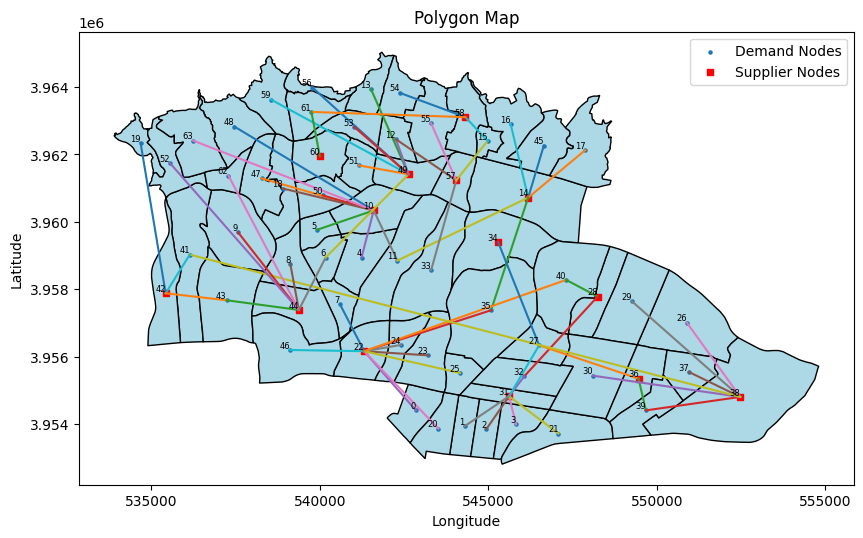

In [113]:
def chromosomplot(bestsolution):
    
# display shp file
    shapefile_path = "C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\Mahallat\\Reg1_3_4.shp"
    polygons = gpd.read_file(shapefile_path)
    # print(polygons.head())
    polygons.plot(edgecolor='black', facecolor='lightblue', figsize=(10, 8))
    plt.title("Polygon Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

# display nodes
    x_d = []
    y_d = []
    x_s = []
    y_s = []
    for i in demand_nodes_index:
        x_d.append(x_nodes[i])
        y_d.append(y_nodes[i])
    plt.scatter(x_d, y_d, s=5)
    for i in supplier_nodes_index:
        x_s.append(x_nodes[i])
        y_s.append(y_nodes[i])
    plt.scatter(x_s, y_s, c='r', s=15, marker='s')
    plt.legend(["Demand Nodes","Supplier Nodes"])
    
    for n, txt in enumerate(range(No_nodes)):
        plt.text(x_nodes[n], y_nodes[n], n, fontsize=6, ha='right', va='bottom')
    
# display allocating nodes
    d_supp = np.array([v_demands[s] for s in supplier_nodes_index])
    c_supp = np.array([i*V  for i in best_solution[No_demandNodes:]]) - d_supp
    d = np.array([v_demands[i] for i in demand_nodes_index])
    j = 0
    end = False
    for i in range(No_supplierNodes):
        x = []
        y = []
        print(f"c_supp = {c_supp} \n d = {d} \n")
        while c_supp[i] >= d[j]:
            c_supp[i] -= d[j]
            d[j] = 0
            print(f"c_supp = {c_supp} \n d = {d} \n")
            x.append(x_nodes[supplier_nodes_index[i]])
            y.append(y_nodes[supplier_nodes_index[i]])
            x.append(x_nodes[bestsolution[j]])
            y.append(y_nodes[bestsolution[j]])
            plt.plot(x,y)
            x= []
            y = []
            j += 1
            if j == No_demandNodes:
                end = True
                break
        if end == True:
            break
        d[j] -= c_supp[i]
        c_supp[i] = 0
        print(f"c_supp = {c_supp} \nd = {d} \n")
        x.append(x_nodes[supplier_nodes_index[i]])
        y.append(y_nodes[supplier_nodes_index[i]])
        x.append(x_nodes[bestsolution[j]])
        y.append(y_nodes[bestsolution[j]])
        plt.plot(x,y)
    plt.figure(1)
    plt.show()
chromosomplot(best_solution)    

In [7]:
a = {
    '1':[1,2,3],
    '2':[4,5,6],
    '3':[7,8,9]
}

for index, i in enumerate(a.keys):
    print(i)

TypeError: 'builtin_function_or_method' object is not iterable